In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using ModelingToolkit, FenrirForNeuro, OrdinaryDiffEq

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        df[!, :iter] = 1:size(df, 1)
        push!(dfs, df)
    end
    return dfs
end

d_norm(X, y) = sqrt.(sum(((X .- y) ./ y) .^ 2, dims=[2]))

function val_at(p, x, y)
    idx = argmin(abs.(x .- p))
    return y[idx]
end

val_at (generic function with 1 method)

In [3]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = HALF_WIDTH # inches
PT_PER_INCH = 72

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

"../../figures/"

In [7]:
p_str = "gNa"
fpath = RESULTS_PATH*"hh/1p/simple/fenrir/loss_$p_str/hh-1p-simple-fenrir-loss_$p_str-1-100.csv"

T(t::Real)::Float64 = 10.0^(20.0 - t)
tempering_schedule = T.(LinRange(0, 20, 21))
header = [p_str, [@sprintf("%.0e", κ²) for κ² in tempering_schedule]...]
loss_surface = CSV.read(fpath, DataFrame, header=header)

Row,gNa,1e+20,1e+19,1e+18,1e+17,1e+16,1e+15,1e+14,1e+13,1e+12,1e+11,1e+10,1e+09,1e+08,1e+07,1e+06,1e+05,1e+04,1e+03,1e+02,1e+01,1e+00
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,34487.2,23123.0,13032.9,12480.0,67064.1,4.10933e5,1.5982e6,3.82357e6,6.48044e6,9.12118e6,1.22002e7,1.41017e7,1.4448e7,1.44858e7,1.44896e7,1.449e7,1.44901e7,1.44901e7,1.44901e7,1.44901e7,1.44901e7
2,1.30303,34556.5,23184.0,13011.0,11661.6,59569.2,3.66437e5,1.45193e6,3.5651e6,6.16755e6,8.71508e6,1.17302e7,1.41439e7,1.46889e7,1.47511e7,1.47575e7,1.47581e7,1.47582e7,1.47582e7,1.47582e7,1.47582e7,1.47582e7
3,2.10606,34677.8,23295.0,13019.9,10702.3,50612.4,3.13495e5,1.27542e6,3.24204e6,5.7761e6,8.23361e6,1.10413e7,1.40414e7,1.49947e7,1.51145e7,1.51268e7,1.5128e7,1.51282e7,1.51282e7,1.51282e7,1.51282e7,1.51282e7
4,2.90909,34898.2,23503.9,13115.9,9756.41,41181.5,2.56087e5,1.07145e6,2.83217e6,5.25931e6,7.64236e6,1.01133e7,1.34607e7,1.5351e7,1.56529e7,1.56849e7,1.56881e7,1.56885e7,1.56885e7,1.56885e7,1.56885e7,1.56885e7
5,3.71212,35513.3,24123.1,13780.6,11105.3,50457.6,3.27778e5,1.42888e6,3.76148e6,6.7521e6,9.37613e6,1.18936e7,1.48446e7,1.6428e7,1.70331e7,1.73195e7,1.74133e7,1.74396e7,1.74504e7,1.74521e7,1.74523e7,1.74523e7
6,4.51515,35334.2,24014.0,14368.9,18475.7,1.1849e5,766558.0,2.77355e6,5.62881e6,8.4048e6,1.09098e7,1.38847e7,1.56617e7,1.60915e7,1.61672e7,1.62446e7,1.63249e7,1.63517e7,1.63552e7,1.63556e7,1.63556e7,1.63556e7
7,5.31818,35295.2,24010.2,14716.5,22274.7,1.53216e5,1.00029e6,3.65266e6,7.36052e6,1.06441e7,1.36969e7,1.65854e7,1.78627e7,1.81537e7,1.81923e7,1.8197e7,1.81983e7,1.81986e7,1.81987e7,1.81987e7,1.81987e7,1.81987e7
8,6.12121,35299.7,24013.4,14705.7,22122.9,1.52007e5,9.96845e5,3.64561e6,7.27176e6,1.05591e7,1.39277e7,1.69041e7,1.84456e7,1.87994e7,1.88442e7,1.8849e7,1.88496e7,1.88497e7,1.88497e7,1.88497e7,1.88497e7,1.88497e7
9,6.92424,35333.2,24036.9,14629.7,21070.7,1.42302e5,9.3655e5,3.47623e6,7.06407e6,1.04311e7,1.39416e7,1.69089e7,1.88202e7,1.92609e7,1.93133e7,1.9319e7,1.93198e7,1.93199e7,1.932e7,1.932e7,1.932e7,1.932e7


In [23]:
fpath = RESULTS_PATH * "hh/1p/simple/fenrir/tempered_diff_$p_str/"
fnames = [name for name in readdir(fpath)]
trajectories = import_csvs(fpath, fnames, [Symbol(p_str), :κ², :loss, :T])

trajectories_at_κ² = []
for trajectory in trajectories
    trajectory_at_κ² = [trajectory[log.(trajectory[!, :κ²]).==log.(κ²), :] for κ² in tempering_schedule]
    push!(trajectories_at_κ², trajectory_at_κ²)
end

In [10]:
@parameters gNa
θ = [gNa => 25]
prob_prior, prob = get_SinglecompartmentHH(θ)

proj = [1 0 0 0]
observation = generate_data(prob, proj, 0, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100.0], u = [[-70.0], [-69.99999986016917], [-69.9999997204781], [-69.99999958092664], [-69.99999944151466], [-69.99999930224202], [-69.99999916310858], [-69.9999990241142], [-69.99999888525873], [-69.99999874654203]  …  [-65.41773466442645], [-65.42231183298583], [-65.42688443476916], [-65.4314524743088], [-65.43601595613706], [-65.44057488478626], [-65.44512926478873], [-65.44967910067682], [-65.45422439698282], [-65.45876515823909]])

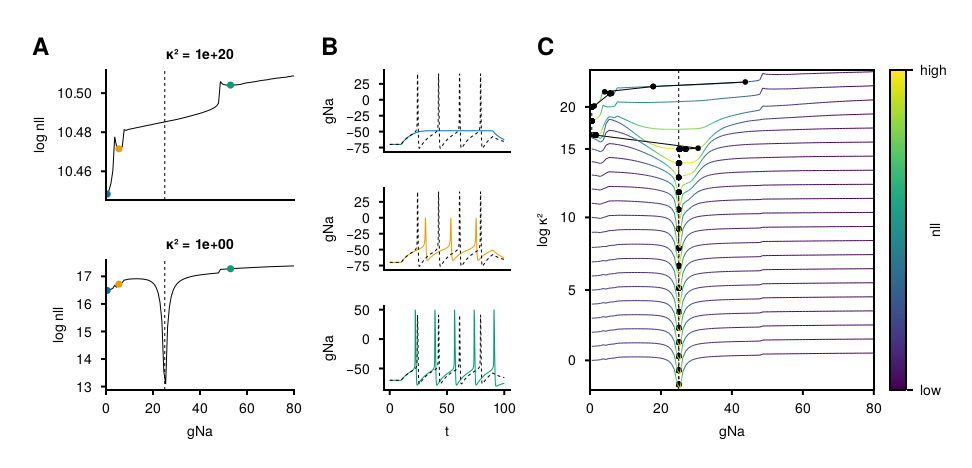

In [30]:
p = loss_surface[:, p_str]
idxs = [1, 21]
params_of_interest = [0.5, 5.5, 53]

f = Figure(size=(PT_PER_INCH * FULL_WIDTH, PT_PER_INCH * HEIGHT))
nll_axes = f[1, 1] = GridLayout()
ode_axes = f[1, 2] = GridLayout()
opt_axes = f[1, 3] = GridLayout()

left_axes = []
for (i, idx) in enumerate(idxs)
    ax = Axis(nll_axes[i, 1], xlabel=p_str, ylabel="log nll", title=@sprintf("κ² = %.0e", tempering_schedule[idx]), titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)
    lines!(ax, p, log.(loss_surface[:, 1+idx]), color=:black, linewidth=0.5, linestyle=:solid, label=header[idx])
    vlines!(ax, [25], color=:black, linewidth=0.5, linestyle=:dash, label="true")
    xlims!(ax, (0.0, 80))
    hidespines!(ax, :r, :t)
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)
    push!(left_axes, ax)
end
scatter!(left_axes[1], params_of_interest, [val_at(pᵢ, p, log.(loss_surface[:, 1+idxs[1]])) for pᵢ in params_of_interest], color=Makie.wong_colors()[1:3], label=header[idxs[1]], markersize=5)
scatter!(left_axes[2], params_of_interest, [val_at(pᵢ, p, log.(loss_surface[:, 1+idxs[2]])) for pᵢ in params_of_interest], color=Makie.wong_colors()[1:3], label=header[idxs[2]], markersize=5)
hidexdecorations!(left_axes[1])
linkxaxes!(left_axes...)


middle_axes = []
for (i, (l, c)) in enumerate(zip(params_of_interest, Makie.wong_colors()[1:3]))
    ax = Axis(ode_axes[i, 1], xlabel="t", ylabel="gNa", titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)
    data = generate_data(remake(prob, p=[l]), proj, 0, 1e-2)
    lines!(ax, data.t, vcat(data.u...), linewidth=0.5, linestyle=:solid, color=c)
    lines!(ax, observation.t, vcat(observation.u...), linewidth=0.5, linestyle=:dash, label="true", color=:black)
    if length(middle_axes) > 0
        linkxaxes!(middle_axes[1], ax)
    end
    hidespines!(ax, :r, :t)
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)
    push!(middle_axes, ax)
end

hidexdecorations!.(middle_axes[1:2], label=true, ticks=true, ticklabels=true)

p = loss_surface[:, p_str]

pad = 0.4
ls = log.(Array(loss_surface[:, 2:end]))
max_ls, min_ls = maximum(ls, dims=1), minimum(ls, dims=1)
yticks = 1 .- (ls[1, :] .- min_ls[1, :]) ./ (max_ls[1, :] .- min_ls[1, :]) + (collect(0:20) * pad)
# yticklabels = [@sprintf("%.0e", κ²) for κ² in tempering_schedule]
yticklabels = [@sprintf("%.0f", log10(κ²)) for κ² in tempering_schedule]

ax = Axis(opt_axes[1, 1], ylabel="log κ²", xlabel=p_str, titlesize=6, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2, yticks=(yticks[1:5:end], yticklabels[1:5:end]), yreversed=true)
vlines!(ax, [25], color=:black, linewidth=0.5, linestyle=:dash, label="true")

prev_endpoint = nothing
for (i, T) in enumerate(tempering_schedule)
    log_nll = log.(loss_surface[:, 1+i])
    rescale(l) = (l .- minimum(log_nll)) ./ (maximum(log_nll) - minimum(log_nll))
    flip(l) = 1 .- l
    add_padding(l) = l .+ (pad * (i - 1))

    norm_log_nll = rescale(log_nll)
    norm_log_nll = flip(norm_log_nll)
    padded_log_nll = add_padding(norm_log_nll)

    # lines!(ax, padded_log_nll, p, color=:black, linewidth=0.5, linestyle=:solid, label=header[i+1])
    lines!(ax, p, padded_log_nll, color=norm_log_nll, colormap=:viridis, colorrange=[minimum(norm_log_nll), maximum(norm_log_nll)], linewidth=0.5, linestyle=:solid, label=header[i+1])

    for (k, trajectory_at_κ²) in enumerate(trajectories_at_κ²[2:2])
        t = trajectory_at_κ²[i]
        norm_t_loss = (log.(Array(t[!, :loss])) .- minimum(log_nll)) / (maximum(log_nll) - minimum(log_nll))
        norm_t_loss = flip(norm_t_loss)
        log_t_loss = add_padding(norm_t_loss)

        if size(t, 1) > 1
            lines!(ax, Array(t[!, p_str]), log_t_loss, color=:black, label="T=$(T)", linewidth=0.5)
            scatter!(ax, Array(t[!, p_str]), log_t_loss, color=:black, label="T=$(T)", markersize=4)

            if prev_endpoint != nothing
                lines!(ax, [prev_endpoint[2], t[1, p_str]], [prev_endpoint[1], log_t_loss[1]], linewidth=0.5, linestyle=:dash, color=:black)
            end
            prev_endpoint = [log_t_loss[end], t[end, p_str]]
        end
    end


    # hidexdecorations!(ax)
    xlims!(ax, (0, 80 + 0.05))
    ylims!(ax, (pad * length(tempering_schedule) + (1 - pad) + 0.05, -0.05))
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)

end
cbar = Colorbar(opt_axes[1, 2], label="nll", ticklabelsize=7, limits=(0, 1), labelsize=7, ticks=([0, 1], ["low", "high"]), size=8, ticksize=3, labelpadding=-10)
colgap!(opt_axes, 1, Relative(0.05))


colsize!(f.layout, 1, Relative(0.3))
colsize!(f.layout, 2, Relative(0.2))
colgap!(f.layout, Relative(0.04))

Label(f.layout[1, 1, TopLeft()], "A", fontsize=12, font=:bold, padding=(0, 5, 5, 0), halign=:left)
Label(f.layout[1, 2, TopLeft()], "B", fontsize=12, font=:bold, padding=(0, 5, 5, 0), halign=:left)
Label(f.layout[1, 3, TopLeft()], "C", fontsize=12, font=:bold, padding=(0, 5, 5, 0), halign=:left)

f

In [32]:
save(joinpath(FIGURES_PATH, "appendix_figure1.pdf"), f, overwrite=true)

CairoMakie.Screen{IMAGE}
